In [1]:
import os
import re
import copy
import numpy as np
import pandas as pd
from scipy.signal import convolve2d
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import spectral.io.envi as envi
import rampy as rp
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import seaborn as sns
from skimage import measure
from skimage.transform import probabilistic_hough_line, hough_line_peaks, hough_line
from skimage.feature import canny
from scipy.stats import mode
from sklearn.mixture import GaussianMixture
from skimage.measure import block_reduce
from scipy.signal import savgol_filter
import tensorflow as tf

In [2]:
def open_shit(filepath):
    
    shifts = pd.read_csv('shifts.csv', engine = 'python', sep = '\t', header = None).to_numpy().flatten()
    roi = np.array([[0,1500],[1700,2500],[2850,3399]])

    img = envi.open(filepath)
    arr = []

    for x in range(img.shape[0]):

        for y in range(img.shape[1]):

            temp = img.read_pixel(x,y)
            arr.append(temp)
    
    return arr

In [3]:
def resistances(names):
    
    path = r'C:\jupyter_workspace\Lab\Raman\0.02CO2_3Hz_maps'
    files = os.listdir(path)
    labels = []
    spec = []
    
    for name in names:
        
        for file in files:
            
            if name in file and '.hdr' in file:
                
                spec.append(open_shit(path + '\\' + file))
                labels.append(file.replace('.hdr', ''))
                
    return spec, labels

raw, labels = resistances(['55MOhm', '130MOhm'])

In [8]:
import torch

In [17]:
a = torch.tensor([[1,2], [3,4]], device = torch.device('cuda'))

In [19]:
torch.tensor?

In [7]:
for i,j in zip([0,1], [2,3]):
    print(i, j)

0 2
1 3


In [169]:
shot_list = []

for item in raw:
    
    inputs = tqdm(item)
    shot_list.append(Parallel(8)(delayed(calc)(spec,shifts, roi) for spec in inputs))

100%|██████████████████████████████████████████████████████████████████████████████| 1936/1936 [01:16<00:00, 25.34it/s]


In [4]:
def smth(processed_list):
    
    k = np.array(processed_list)
    k = k.reshape((int(len(processed_list)**0.5),int(len(processed_list)**0.5),2,1738))
    df_list = pd.DataFrame(columns=['Intensity', 'Shift'])
    df_list['Shift'] = shifts
    df_ig = pd.DataFrame(columns = ['x','y','I'])
    df_i2d = pd.DataFrame(columns = ['x','y','I'])
    df_sio2 = pd.DataFrame(columns = ['x','y','I'])

    for x in range(img.shape[0]):

        for y in range(img.shape[1]):

            if np.mean(k[x,y,0,:]) < 100:

                k[x,y,0,:] /= 100

            df_list['Intensity'] = k[x, y, 0, :]

            df_ig = df_ig.append({'x': x, 'y': y, 'I': np.max(df_list['Intensity'][(df_list['Shift'] > 1400) & (df_list['Shift'] < 1700)])}, ignore_index=True)
            df_i2d = df_i2d.append({'x': x, 'y': y, 'I': np.max(df_list['Intensity'][(df_list['Shift'] > 2500) & (df_list['Shift'] < 3000)])}, ignore_index=True)
            df_sio2 = df_sio2.append({'x': x, 'y': y, 'I': np.max(df_list['Intensity'][(df_list['Shift'] > 400) & (df_list['Shift'] < 600)])}, ignore_index=True)
    
    matrix_sio2 = np.abs(df_sio2.pivot(columns='x', index='y', values='I')).to_numpy()
    matrix_ig = np.abs(df_ig.pivot(columns='x', index='y', values='I')).to_numpy()
    matrix_i2d = np.abs(df_i2d.pivot(columns='x', index='y', values='I')).to_numpy()
    
    return [matrix_sio2, matrix_ig, matrix_i2d]

In [5]:
def plot_shit(mat_array, label):
    
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(17, 4.5)
    im0 = ax[0].imshow(mat_array[0], origin='lower', cmap=cm.rainbow, aspect='auto', norm = mpl.colors.LogNorm(), vmin = 1e1, vmax = 1e5)
    cb0 = fig.colorbar(im0, orientation='vertical', shrink=0.85, norm = mpl.colors.LogNorm(), ax = ax[0])
    ax[0].set_title('$SiO_{2}$')
    im1 = ax[1].imshow(mat_array[1], origin='lower', cmap=cm.rainbow, aspect='auto', norm = mpl.colors.LogNorm(), vmin = 10**2, vmax = 10**5)
    cb1 = fig.colorbar(im1, orientation='vertical', shrink=0.85, norm = mpl.colors.LogNorm(), ax = ax[1])
    ax[1].set_title('$I_{G}$')
    im2 = ax[2].imshow(mat_array[2], origin='lower', cmap=cm.rainbow, aspect='auto', norm = mpl.colors.LogNorm(), vmin = 10**2, vmax = 10**3)
    ax[2].set_title('$I_{2D}$')
    cb2 = fig.colorbar(im2, orientation='vertical', shrink=0.85, norm = mpl.colors.LogNorm(), ax = ax[2])
    plt.suptitle(label)

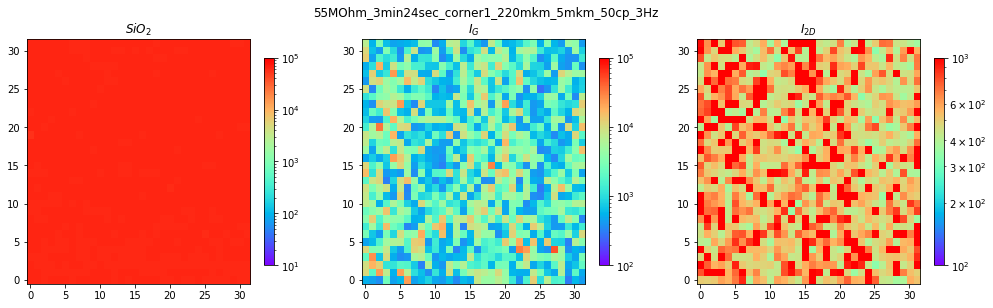

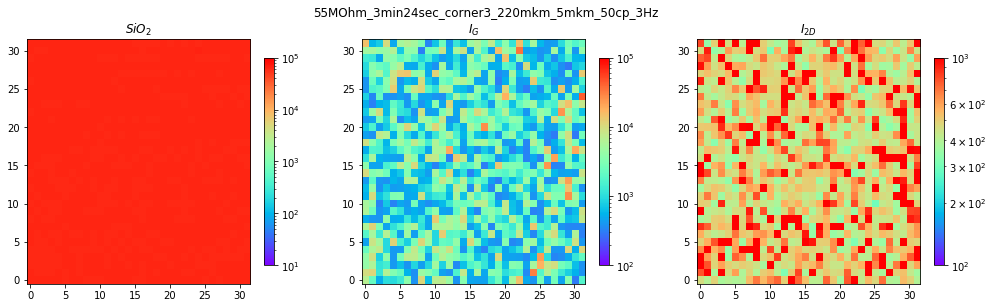

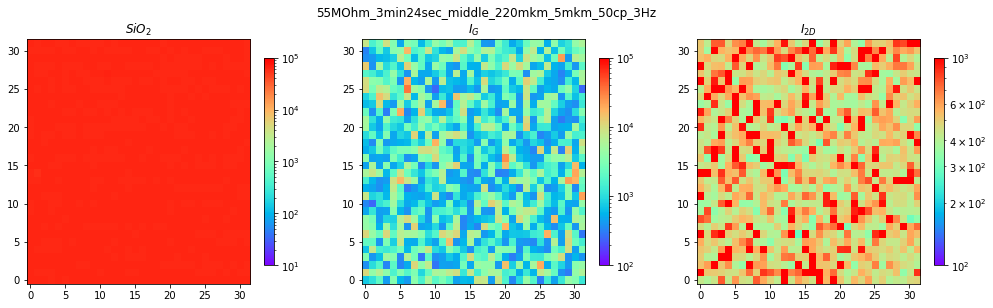

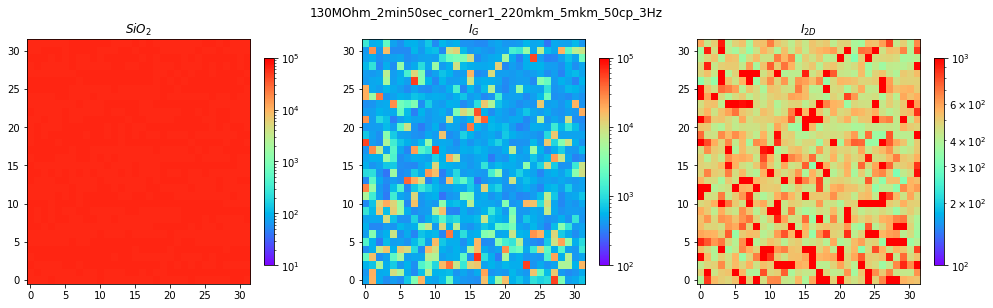

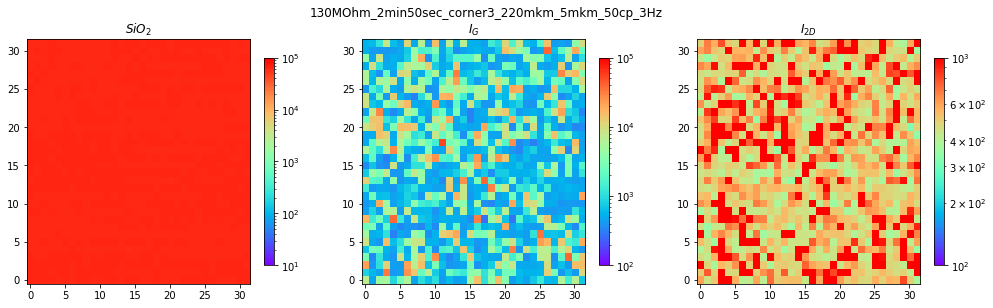

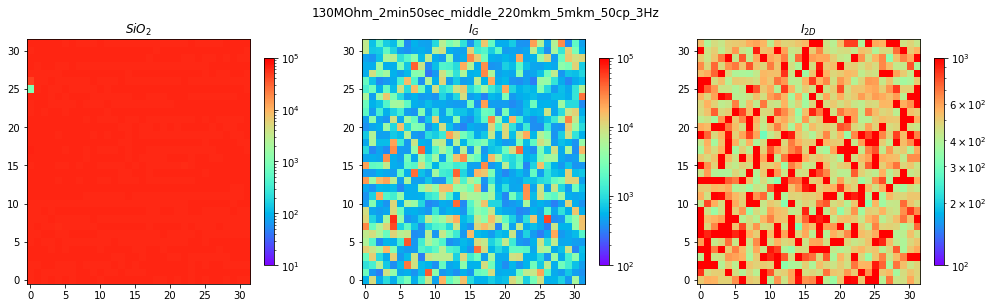

In [183]:
data_list = list(map(smth, shot_list))

for data, label in zip(data_list, labels):
    
    plot_shit(data, label)

In [156]:
filename = '32MOhm_FET_1_1_10mW_2Hz_1mkm_120mkm_50cp_50x'
shifts = pd.read_csv('shifts.csv', engine = 'python', sep = '\t', header = None).to_numpy().flatten()
roi = np.array([[0,1500],[1700,2500],[2850,3399]])

img = envi.open(filename + r'.hdr')
arr = []

for x in range(img.shape[0]):

    for y in range(img.shape[1]):

        temp = img.read_pixel(x,y)
        arr.append(temp)

In [158]:
def calc(spectra, shifts, roi):
    
    ycalc_poly, base_poly = rp.baseline(x_input = np.array(shifts), 
                                        y_input = spectra, 
                                        bir = roi, 
                                        method = 'arPLS', 
                                        lab = 10 **6)
    
    return ycalc_poly, base_poly

inputs = tqdm(arr)
parameters = (shifts, roi)

processed_list = Parallel(8)(delayed(calc)(spec,shifts, roi) for spec in inputs)

100%|████████████████████████████████████████████████████████████████████████████| 14400/14400 [09:20<00:00, 25.70it/s]


In [159]:
k = np.array(processed_list)
k = k.reshape((img.shape[0],img.shape[1],2,1738))
df_list = pd.DataFrame(columns=['Intensity', 'Shift'])
df_list['Shift'] = shifts
df_ig = pd.DataFrame(columns = ['x','y','I'])
df_i2d = pd.DataFrame(columns = ['x','y','I'])
df_sio2 = pd.DataFrame(columns = ['x','y','I'])

for x in range(img.shape[0]):
    
    for y in range(img.shape[1]):
        
        if np.mean(k[x,y,0,:]) < 100:
        
            k[x,y,0,:] /= 100
            
        df_list['Intensity'] = k[x, y, 0, :]
        
        df_ig = df_ig.append({'x': x, 'y': y, 'I': np.max(df_list['Intensity'][(df_list['Shift'] > 1400) & (df_list['Shift'] < 1700)])}, ignore_index=True)
        df_i2d = df_i2d.append({'x': x, 'y': y, 'I': np.max(df_list['Intensity'][(df_list['Shift'] > 2500) & (df_list['Shift'] < 3000)])}, ignore_index=True)
        df_sio2 = df_sio2.append({'x': x, 'y': y, 'I': np.max(df_list['Intensity'][(df_list['Shift'] > 400) & (df_list['Shift'] < 600)])}, ignore_index=True)

In [160]:
matrix_sio2 = np.abs(df_sio2.pivot(columns='x', index='y', values='I'))
matrix_sio2.to_csv(filename + '_sio2.csv', header = None, index = False, sep = '\t')
matrix_sio2 = matrix_sio2.to_numpy()
matrix_ig = np.abs(df_ig.pivot(columns='x', index='y', values='I'))
matrix_ig.to_csv(filename + '_ig.csv', header = None, index = False, sep = '\t')
matrix_ig = matrix_ig.to_numpy()
matrix_i2d = np.abs(df_i2d.pivot(columns='x', index='y', values='I'))
matrix_i2d.to_csv(filename + '_i2d.csv', header = None, index = False, sep = '\t')
matrix_i2d = matrix_i2d.to_numpy()

In [8]:
matrix_sio2[:, :4] = 5*1e4
matrix_sio2[5:26, 4:28] = 5*1e4
matrix_sio2[26, 16:18] = 10

In [157]:
matrix_ig = pd.read_csv(filename + '_ig.csv', engine = 'python', sep = '\t', header = None).to_numpy()
matrix_sio2 = pd.read_csv(filename + '_sio2.csv', engine = 'python', sep = '\t', header = None).to_numpy()
matrix_i2d = pd.read_csv(filename + '_i2d.csv', engine = 'python', sep = '\t', header = None).to_numpy()

FileNotFoundError: [Errno 2] No such file or directory: '32MOhm_FET_1_1_10mW_2Hz_1mkm_120mkm_50cp_50x_ig.csv'

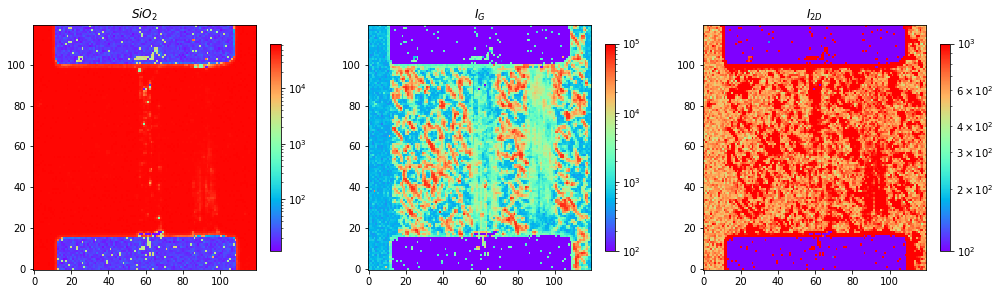

In [161]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(17, 4.5)
im0 = ax[0].imshow(matrix_sio2, origin='lower', cmap=cm.rainbow, aspect='auto', norm = mpl.colors.LogNorm())
cb0 = fig.colorbar(im0, orientation='vertical', shrink=0.85, norm = mpl.colors.LogNorm(), ax = ax[0])
ax[0].set_title('$SiO_{2}$')
im1 = ax[1].imshow(matrix_ig, origin='lower', cmap=cm.rainbow, aspect='auto', norm = mpl.colors.LogNorm(), vmin = 10**2, vmax = 10**5)
cb1 = fig.colorbar(im1, orientation='vertical', shrink=0.85, norm = mpl.colors.LogNorm(), ax = ax[1])
ax[1].set_title('$I_{G}$')
im2 = ax[2].imshow(matrix_i2d, origin='lower', cmap=cm.rainbow, aspect='auto', norm = mpl.colors.LogNorm(), vmin = 10**2, vmax = 10**3)
ax[2].set_title('$I_{2D}$')
cb2 = fig.colorbar(im2, orientation='vertical', shrink=0.85, norm = mpl.colors.LogNorm(), ax = ax[2])

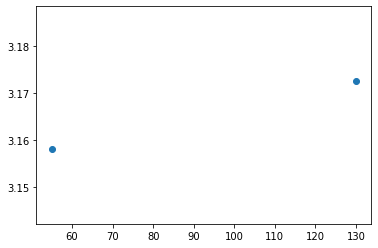

In [195]:
def rbc(array):
    
    m = 0
    
    for item in array:

        m += np.mean(np.log10(item[1]))/len(array)
        
    return m
        
plt.scatter([55,130], list(map(rbc, [data_list[:4], data_list[4:]])))

In [194]:
data_list[:4][1][0]

array([[62684.89927053, 63642.46728955, 63182.68004093, ...,
        62814.08436133, 62822.66879215, 62894.59592485],
       [62960.70718671, 62435.44293893, 62339.5176374 , ...,
        62896.76407491, 62857.5505763 , 63538.40178246],
       [62455.40105038, 62479.39286129, 62442.33482171, ...,
        63255.91572201, 62661.71649074, 64094.78184526],
       ...,
       [62577.94321311, 64813.8091472 , 64349.20614855, ...,
        62690.57299653, 62675.75235458, 62368.78814947],
       [63506.42804884, 62605.4574421 , 62502.00143766, ...,
        63948.22687076, 64784.44122574, 63853.01840908],
       [62793.89430619, 63901.42870663, 63709.22259758, ...,
        63272.98850269, 64085.28774107, 64469.21732469]])

Text(0.5, 1.0, '130MOhm')

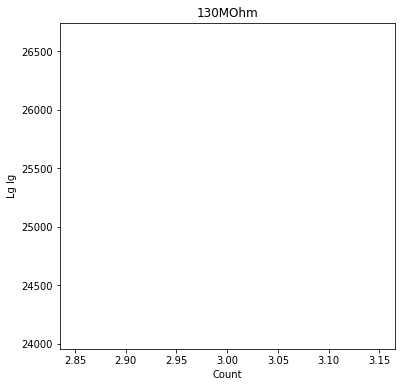

In [61]:
fig, ax = plt.subplots(figsize = (6,6))
plt.errorbar([1,2,3,4,5], np.mean(np.ma.masked_where(data75 < 10**4, data75), axis = (1,2)), np.std(np.ma.masked_where(data75 < 10**4, data75), axis = (1,2)))
plt.xlabel('Count')
plt.ylabel('Lg Ig')
plt.title('130MOhm')

In [145]:
matrix_ig = pd.read_csv(filename + '_ig.csv', engine = 'python', sep = '\t', header = None).to_numpy()
matrix_sio2 = pd.read_csv(filename + '_sio2.csv', engine = 'python', sep = '\t', header = None).to_numpy()
matrix_i2d = pd.read_csv(filename + '_i2d.csv', engine = 'python', sep = '\t', header = None).to_numpy()

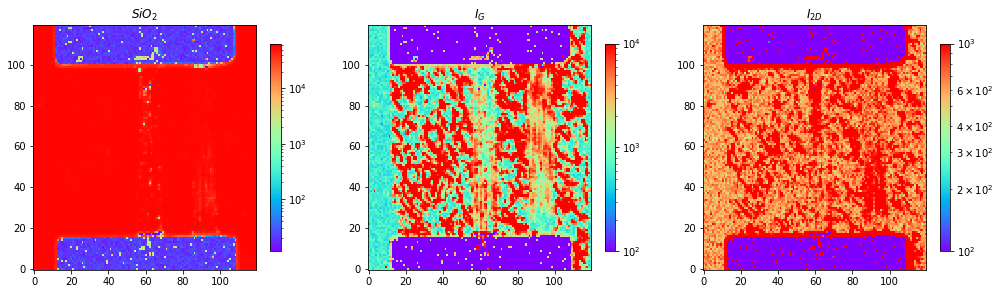

In [162]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(17, 4.5)
im0 = ax[0].imshow(matrix_sio2, origin='lower', cmap=cm.rainbow, aspect='auto', norm = mpl.colors.LogNorm())
cb0 = fig.colorbar(im0, orientation='vertical', shrink=0.85, norm = mpl.colors.LogNorm(), ax = ax[0])
ax[0].set_title('$SiO_{2}$')
im1 = ax[1].imshow(matrix_ig, origin='lower', cmap=cm.rainbow, aspect='auto', norm = mpl.colors.LogNorm(), vmin = 10**2, vmax = 10**4)
cb1 = fig.colorbar(im1, orientation='vertical', shrink=0.85, norm = mpl.colors.LogNorm(), ax = ax[1])
ax[1].set_title('$I_{G}$')
im2 = ax[2].imshow(matrix_i2d, origin='lower', cmap=cm.rainbow, aspect='auto', norm = mpl.colors.LogNorm(), vmin = 10**2, vmax = 10**3)
ax[2].set_title('$I_{2D}$')
cb2 = fig.colorbar(im2, orientation='vertical', shrink=0.85, norm = mpl.colors.LogNorm(), ax = ax[2])

In [163]:
def process(mtx):
    
    filt = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

    test1 = convolve2d(np.log10(mtx), filt, mode = 'same')
    test2 = convolve2d(np.log10(mtx), filt.T, mode = 'same')

    inter = (np.abs(test1) + np.abs(test2))/np.max((np.abs(test1) + np.abs(test2)))
    print(np.max(inter))
    k = np.max(inter)/4
    inter[inter >= k] = k
    inter[inter < k] = 0
    inter = inter/np.max(inter)
    
    return inter

In [172]:
def find_lines(inter):
    
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
    lines = probabilistic_hough_line(inter, theta=tested_angles, threshold = 30, line_length = 2)

    # Generating figure 1
    origin = np.array((0, inter.shape[1]))
    fig, axes = plt.subplots(2, 1, figsize=(6, 10))
    ax = axes.ravel()

    ax[0].imshow(inter, cmap=cm.gray)
    ax[0].set_title('Input image')
    ax[0].set_xlim(origin)
    ax[0].set_ylim((inter.shape[0], 0))

#     ax[1].imshow(np.log(1 + h),
#                  extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
#                  cmap=cm.gray, aspect=1/1.5)
#     ax[1].set_title('Hough transform')
#     ax[1].set_xlabel('Angles (degrees)')
#     ax[1].set_ylabel('Distance (pixels)')
#     ax[1].axis('image')

    ax[1].imshow(inter, cmap=cm.gray)
    y = []
    
    for line in lines:
        
        k = (line[1][1] - line[0][1])/(line[1][0] - line[0][0] + 1e-12)
        b = line[1][1] - k * line[1][0]
        y0, y1 = (k * origin + b)
        ax[1].plot(origin, (y0, y1), '-r')
        y.append((y0, y1))
        
    ax[1].set_xlim(origin)
    ax[1].set_ylim((inter.shape[0], 0))
    # ax[2].set_axis_off()
    ax[1].set_title('Detected lines')

    plt.tight_layout()
    plt.show()
    
    return y

In [173]:
# def find_lines(inter):
    
#     tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 3600)
#     h, theta, d = hough_line(inter, theta=tested_angles)

#     # Generating figure 1
#     fig, axes = plt.subplots(1, 3, figsize=(15, 6))
#     ax = axes.ravel()

#     ax[0].imshow(inter, cmap=cm.gray)
#     ax[0].set_title('Input image')
#     ax[0].set_axis_off()

#     ax[1].imshow(np.log(1 + h),
#                  extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
#                  cmap=cm.gray, aspect=1/1.5)
#     ax[1].set_title('Hough transform')
#     ax[1].set_xlabel('Angles (degrees)')
#     ax[1].set_ylabel('Distance (pixels)')
#     ax[1].axis('image')

#     ax[2].imshow(inter, cmap=cm.gray)
#     origin = np.array((0, inter.shape[1]))
#     y = []
#     for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
#         y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
#         ax[2].plot(origin, (y0, y1), '-r')
#         y.append((y0, y1))
#     ax[2].set_xlim(origin)
#     ax[2].set_ylim((inter.shape[0], 0))
#     # ax[2].set_axis_off()
#     ax[2].set_title('Detected lines')

#     plt.tight_layout()
#     plt.show()
    
#     return y

In [174]:
def get_indices(y, size):
    
    x = np.ones((size, size))
    
    for item in y:
                
        k = (item[1] - item[0]) / size
            
        if abs(k) < 1:
        
            indices = np.ceil(np.arange(0, size, 1) * k + item[0])
                
            if item[0] < size / 2:
                    
                for i in range(size):
                    
                    x[:int(indices[i]), i] = 0
                    
            else:
                
                for i in range(size):
                    
                    x[int(indices[i]):, i] = 0
                    
        else:
            
            point = -item[0]/k
            
            indices = np.ceil(np.arange(0, size, 1) * 1/k + point)
            
            if point < size / 2:
                
                for i in range(size):
                    
                    x[i, :int(indices[i])] = 0
                    
            else:
                
                for i in range(size):
                    
                    x[i, int(indices[i]):] = 0
                    
    return x

1.0


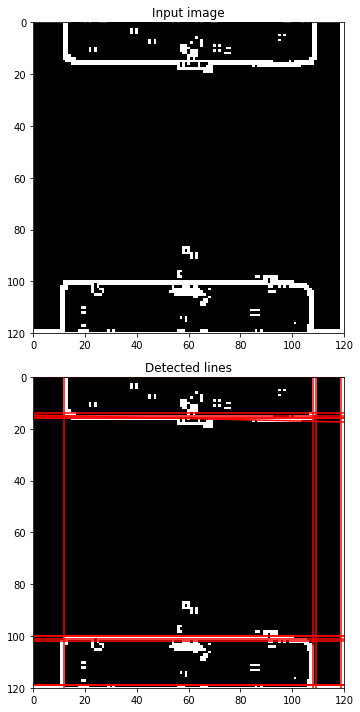

In [175]:
x = get_indices(find_lines(process(matrix_sio2)), matrix_sio2.shape[0])
# x = np.zeros(matrix_sio2.shape)
# x[2:, 5:29] = 1


In [153]:
x[:, :48] = 0
x[:, 240:] = 0

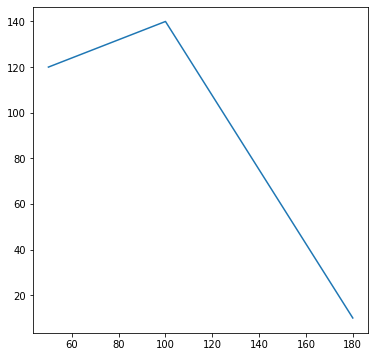

In [198]:
fig, ax = plt.subplots(figsize = (6,6))
# ax.imshow(matrix_sio2)
plt.plot([50,100,180], [120, 140,10])

Text(0.5, 0, 'Lg(Ig)')

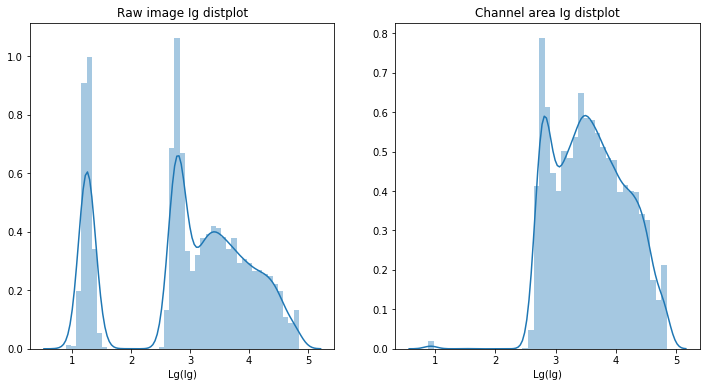

In [176]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 6)

matrix_masked = np.copy(matrix_ig)

for i in range(matrix_masked.shape[0]):
    
    for j in range(matrix_masked.shape[1]):
        
        if x[i,j] < 1:
        
            matrix_masked[i,j] = 1e-6


sns.distplot(np.log10(matrix_ig.flatten()), ax = ax[0])

ax[0].set_title('Raw image Ig distplot')
ax[0].set_xlabel('Lg(Ig)')

sns.distplot(np.log10(matrix_masked.flatten())[(matrix_masked.flatten()) > 1e-6], ax = ax[1])

ax[1].set_title('Channel area Ig distplot')
ax[1].set_xlabel('Lg(Ig)')

Text(0.5, 1.0, '32MOhm_FET_1_1_10mW_2Hz_1mkm_120mkm_50cp_50x\nПокрытие = 97.23659305993691 %')

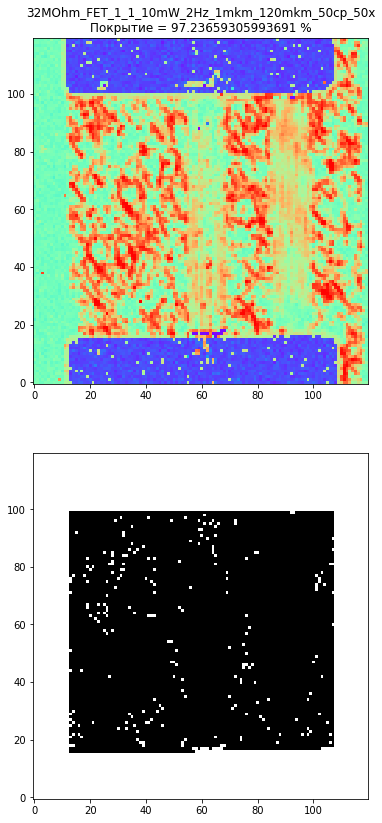

In [177]:
peak_presence = np.copy(matrix_masked)

for i in range(peak_presence.shape[0]):
    
    for j in range(peak_presence.shape[1]):
        
        if peak_presence[i,j] < 500:
            
            peak_presence[i,j] = 1
            
        else:
            
            peak_presence[i,j] = 0
            
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(6, 14)

smth = np.copy(np.log10(matrix_ig))

im1 = ax[0].imshow((smth), origin='lower', cmap=cm.rainbow, aspect='auto')

im2 = ax[1].imshow(np.ma.masked_where(x == 0, peak_presence), origin='lower', cmap=cm.gray, aspect='auto')

coverage = 100*(1 - np.count_nonzero(peak_presence[matrix_masked > 1e-6])/np.size(peak_presence[matrix_masked > 1e-6]))

ax[0].set_title('{}\nПокрытие = {} %'.format(filename, coverage))

In [141]:
coverage

0.04327485380116959

In [22]:
(np.count_nonzero(peak_presence))

81269

In [ ]:
plt.imshow

In [ ]:
shit1 = np.copy(matrix_ig)

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 5)
ax[0].imshow(np.log10(matrix_ig), origin='lower', cmap=cm.rainbow, aspect='auto', vmin = 2, vmax = 4)
ax[0].set_title('Better resolution')
ax[1].imshow(np.log10(shit), origin='lower', cmap=cm.rainbow, aspect='auto', vmin = 2, vmax = 4)
ax[1].set_title('Better resolution, last version')

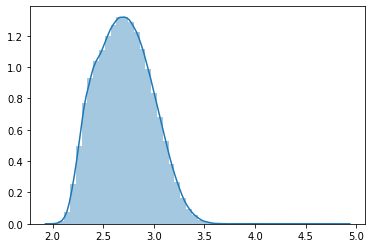

In [31]:
sns.distplot(np.log10(matrix_ig).flatten())

In [40]:
np.argmax(matrix_ig)

59535

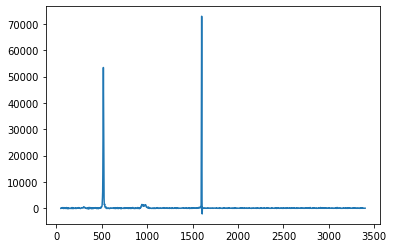

In [48]:
plt.plot(shifts[:], k[375, 116, 0, :])

In [38]:
np.argmax?

In [165]:
a = np.array([0,1,2])

In [166]:
a1 = tf.Variable(a, dtype = 'float64')

In [167]:
a2 = tf.reshape(a1, (-1, 1))

In [168]:
a2

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[0.],
       [1.],
       [2.]])>

In [175]:
mean = tf.math.reduce_mean(a2)
std = tf.math.reduce_std(a2)

In [176]:
a3 = tf.nn.batch_normalization(a2, mean = mean, variance = std**2, offset = 0, scale = 1, variance_epsilon = 0)

In [177]:
a3

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[-1.22474487],
       [ 0.        ],
       [ 1.22474487]])>

In [180]:
a4 = tf.reshape(a3, (len(a)))

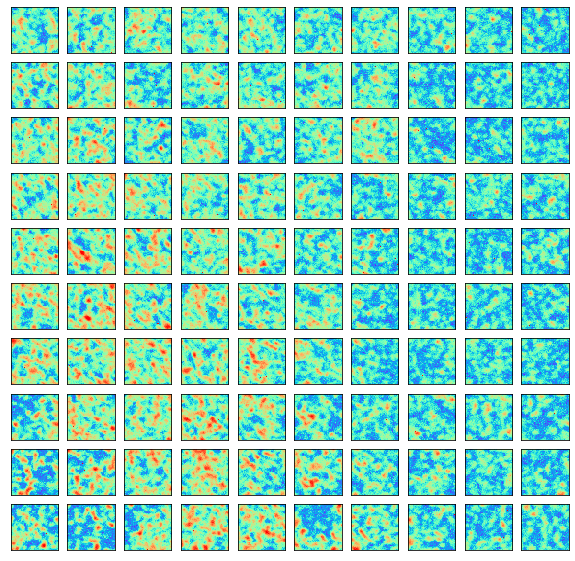

In [70]:
fig, ax = plt.subplots(10, 10)
fig.set_size_inches(10, 10)

for i in range(10):
    
    for j in range(10):
        
        ax[i, j].imshow(matrix_ig[50*i:50*(i+1), 50*j:50*(j+1)], origin='lower', cmap=cm.rainbow, aspect='auto', norm = mpl.colors.LogNorm(), vmin = 1e2, vmax = 4*1e3)
#         cb1 = fig.colorbar(im1, orientation='vertical', shrink=0.85, norm = mpl.colors.LogNorm(), ax = ax[1])
        ax[i,j].axes.get_xaxis().set_visible(False)
        ax[i,j].axes.get_yaxis().set_visible(False)

In [71]:
fig.savefig('shit.png', dpi = 600)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([1.11022302e-16, 1.00000000e+00, 2.00000000e+00])>

In [47]:
np.mean(np.log10(data55[:]), axis = (1,2)).shape

(5,)

In [93]:
probabilistic_hough_line?

In [61]:
hough_line?

In [77]:
to_add_1 = np.repeat(matrix_sio2[0, :], repeats = 100)
to_add_1 = to_add_1.reshape(matrix_sio2.shape[0], 100).T
to_add_1
to_add_2 = np.repeat(matrix_sio2[-1, :], repeats = 100)
to_add_2 = to_add_2.reshape(matrix_sio2.shape[0], 100).T
to_add_2
to_add_3 = np.repeat(matrix_sio2[0, :], repeats = 100)
to_add_3 = to_add_3.reshape(matrix_sio2.shape[0], 100).T
to_add_1
to_add_1 = np.repeat(matrix_sio2[0, :], repeats = 100)
to_add_1 = to_add_1.reshape(matrix_sio2.shape[0], 100).T
to_add_1

array([[60480.7798049 , 61499.75756003, 60902.70453816, ...,
        60455.41347892, 60604.39105258, 59923.72205255],
       [60480.7798049 , 61499.75756003, 60902.70453816, ...,
        60455.41347892, 60604.39105258, 59923.72205255],
       [60480.7798049 , 61499.75756003, 60902.70453816, ...,
        60455.41347892, 60604.39105258, 59923.72205255],
       ...,
       [60480.7798049 , 61499.75756003, 60902.70453816, ...,
        60455.41347892, 60604.39105258, 59923.72205255],
       [60480.7798049 , 61499.75756003, 60902.70453816, ...,
        60455.41347892, 60604.39105258, 59923.72205255],
       [60480.7798049 , 61499.75756003, 60902.70453816, ...,
        60455.41347892, 60604.39105258, 59923.72205255]])

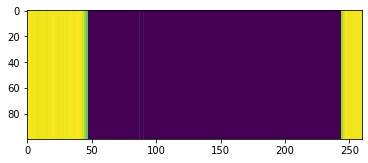

In [78]:
plt.imshow(to_add_2)

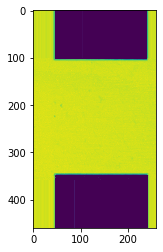

In [79]:
plt.imshow(np.vstack([to_add_1, matrix_sio2, to_add_2]))

In [145]:
for item in x[0]:
    
    print(item)

((259, 259), (259, 0))
((0, 259), (0, 0))
((46, 3), (241, 3))
((46, 247), (243, 247))
((47, 4), (241, 4))
((46, 248), (243, 248))
((1, 259), (48, 259))


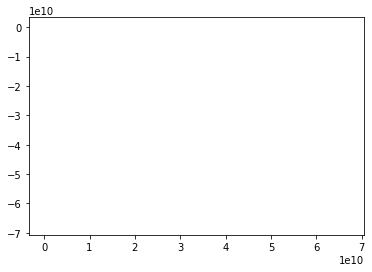

In [244]:
for item in x[0]:

    plt.plot(item[0], item[1])

In [282]:
for item in x[0]:
    
    print(item)

((243, 247), (46, 247))
((241, 4), (47, 4))
((241, 3), (46, 3))
((243, 248), (46, 248))
((259, 259), (259, 119))
((0, 259), (0, 44))
((259, 118), (259, 0))
((0, 43), (0, 0))


In [57]:
x.shape

(32, 32)

In [66]:
x = np.ones((32, 32))

In [70]:
x[:, :4] = 0
x[:, 29:] = 0
x[:1, :] = 0

In [132]:
np.ma.getmask(np.ma.masked_where(x == 0, peak_presence)).isnan()

AttributeError: 'numpy.ndarray' object has no attribute 'isnan'